In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# read data in kaggle directory
The dataset contains 84 character classes, but in this notebook, I will focus on predicting only 50 basic character classes. To achieve this, I will copy the 50 selected classes from the input directory to the Kaggle working directory.

In [3]:


import os
import shutil

import cv2
from tqdm import tqdm

input_path="../input/banglalekha-isolated/BanglaLekha-Isolated/Images/"
# Set the path where you want to create the temporary directory
base_path = '/kaggle/working/'

# Create a temporary directory
temp_dir= os.path.join(base_path, 'temp_directory')
os.makedirs(temp_dir, exist_ok=True)

# Create folders "01" to "12" inside the temporary directory
j=0
for i in range(1,51):
    folder_name = f'{j:02d}'  # Format the folder name with leading zeros
    print(folder_name)
    folder_path = os.path.join(temp_dir, folder_name)
    j=j+1
    #os.makedirs(folder_path, exist_ok=True)
    pth=input_path+str(i)
    fold=os.listdir(pth)
    shutil.copytree(pth, folder_path)



00
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Loading the Dataset and Splitting it into Training, Testing, and Validation Sets

In [4]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    print("define path ok")
    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    dummy_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    train_df,valid_df= train_test_split(dummy_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (64,64)
    channels = 1 # either BGR or Grayscale
    color = 'grayscale'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar,zoom_range=0.1, width_shift_range = 0.1,
                                         height_shift_range = 0.1,rotation_range=15)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

path="/kaggle/working/temp_directory"
#path="../input/banglalekha-isolated/BanglaLekha-Isolated/Images/"

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(path)
    #print(train_df)

    # Get Generators
    batch_size = 32
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

define path ok
Found 71244 validated image filenames belonging to 50 classes.
Found 17811 validated image filenames belonging to 50 classes.
Found 9895 validated image filenames belonging to 50 classes.


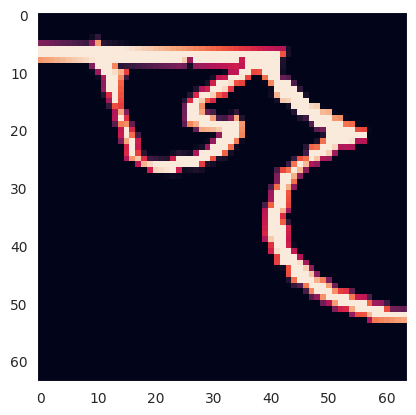

In [5]:
images= next(train_gen)
x=images[0][24]
plt.imshow(x)
plt.grid(False)

# Efficient Channel Attention Block
In the realm of deep learning, attention mechanisms have become critical for improving the performance of neural networks, particularly in computer vision tasks like image classification, object detection, and segmentation.

Efficient Channel Attention (ECA) is a lightweight attention mechanism designed to enhance the performance of convolutional neural networks (CNNs) by focusing on the most important channels (features). Unlike traditional methods like Squeeze-and-Excitation (SE), which reduce dimensionality and can lead to information loss, ECA avoids this reduction by using a simple 1D convolution to model dependencies between channels.

This approach is more computationally efficient and requires fewer parameters, making it ideal for real-time or resource-constrained applications. ECA improves accuracy in tasks like image classification, object detection, and segmentation, while maintaining speed and scalability.

In [6]:
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D
from keras.layers import Input, Conv2D, MaxPooling2D, Multiply,Flatten, Dense, Activation, BatchNormalization, Reshape, Bidirectional, LSTM, Dropout

In [7]:
def efficient_channel_attention(x, reduction_ratio=16):
  

  # Global average pooling to capture channel-wise information
  avg_pool=layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=[1,2]))(x)
  # Reshape for efficient 1D convolution
  avg_pool = layers.Reshape((1, x.shape[-1]))(avg_pool)
  # 1D convolution for local cross-channel interaction
  conv =  tf.keras.layers.Conv1D(filters=1,
    kernel_size=3,
    padding='same',
    kernel_initializer='random_normal',
    use_bias=False)(avg_pool)
  activation = layers.ReLU()(conv)

  # Project back to original channel dimension
  fc = layers.Reshape (( activation.shape[2], 1, 1))(activation)
  #fc = layers.Conv1D(x.shape[-1], kernel_size=1, padding='same')(activation)

  # Attention weights
  attention = layers.Activation('sigmoid')(fc)

  # Apply attention weights to original features
  out = x * attention

  return out

# Residual Block

In [8]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):
    x1 = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x1 = BatchNormalization()(x1)
    x1 =  tf.keras.layers.LeakyReLU()(x1)
    x1 = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x1)
    x1 = BatchNormalization()(x1)
    x = tf.keras.layers.Add()([x1, x])
    x = tf.keras.layers.LeakyReLU()(x)
    return x

# Building Custom CNN model

In [9]:
def conv_block(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
def build_cnn_eca(input_shape=(64,64,1), num_classes=50):
    input_tensor = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (7,7), strides=(1,1), padding="same")(input_tensor)
    x = conv_block(x, 64)
    x = conv_block(x, 64)
    x = efficient_channel_attention(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x=tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(x)
    x=Dropout(rate=0.3)(x)
    
    c1=conv_block(x, 128)
    #c1=conv_block(c1, 128)
    c1=residual_block(c1, 128)
    c1 = efficient_channel_attention(c1)
    p1=MaxPooling2D((2, 2), strides=(2, 2))(c1)
    p1=tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(p1)
    p1=Dropout(rate=0.3)(p1)
    
    c2=conv_block(p1, 256)
    c2=residual_block(c2, 256)
    #c2=residual_block(c2, 256)
    c2 = efficient_channel_attention(c2)
    p2=MaxPooling2D((2, 2), strides=(2, 2))(c2)
    p2=tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(p2)
    p2=Dropout(rate=0.3)(p2)
    
    c3=conv_block(p2, 256)
    #c3=conv_block(c3, 512)
    c3=residual_block(c3, 256)
    p3=MaxPooling2D((2, 2), strides=(2, 2))(c3)
    p3=tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(p3)
    p3=Dropout(rate=0.3)(p3)
    
    
    c5=conv_block(p3, 512)
    c5=conv_block(c5, 512)
    c5 = efficient_channel_attention(c5)
    # Block 5
   

    # Classification head
   
    x = tf.keras.layers.GlobalAveragePooling2D()(c5)
    
    
    x=tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(x)
    
    x=Dropout(rate=0.25)(x)
    x = tf.keras.layers.Dense(256,activation='relu')(x)
    x=Dropout(rate=0.25)(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    

    model = Model(inputs=input_tensor, outputs=x)
    return model

# Create the CNN with ECA model
model = build_cnn_eca()

# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 1)      │        192 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1, 1)      │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 1)   │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 1, 1)   │          0 │ reshape_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ activation_1[0][… │
│                     │ 64)               │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,422,322 (28.31 MB)

 Trainable params: 7,413,746 (28.28 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [10]:
METRICS=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Training Model

In [11]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=METRICS)

history=model.fit(train_gen, epochs=50, batch_size=32,  validation_data = (valid_gen))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725684809.749120      64 service.cc:145] XLA service 0x7c7ac8004310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725684809.749179      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/2227 ━━━━━━━━━━━━━━━━━━━━ 1:27 40ms/step - accuracy: 0.0035 - loss: 4.2268 - precision: 0.0000e+00 - recall: 0.0000e+00       

I0000 00:00:1725684827.888314      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2227/2227 ━━━━━━━━━━━━━━━━━━━━ 144s 51ms/step - accuracy: 0.3222 - loss: 2.5920 - precision: 0.6737 - recall: 0.1804 - val_accuracy: 0.6982 - val_loss: 1.0581 - val_precision: 0.7725 - val_recall: 0.6498
Epoch 2/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - accuracy: 0.8053 - loss: 0.6626 - precision: 0.8760 - recall: 0.7505 - val_accuracy: 0.8341 - val_loss: 0.5727 - val_precision: 0.8830 - val_recall: 0.8009
Epoch 3/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 94s 42ms/step - accuracy: 0.8585 - loss: 0.4948 - precision: 0.9055 - recall: 0.8235 - val_accuracy: 0.8771 - val_loss: 0.4305 - val_precision: 0.9049 - val_recall: 0.8601
Epoch 4/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 95s 42ms/step - accuracy: 0.8814 - loss: 0.4210 - precision: 0.9180 - recall: 0.8544 - val_accuracy: 0.8928 - val_loss: 0.3725 - val_precision: 0.9149 - val_recall: 0.8818
Epoch 5/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - accuracy: 0.8939 - loss: 0.3773 - precision: 0.9252 - recall: 0.8708 - val_accuracy: 0.9102 - va

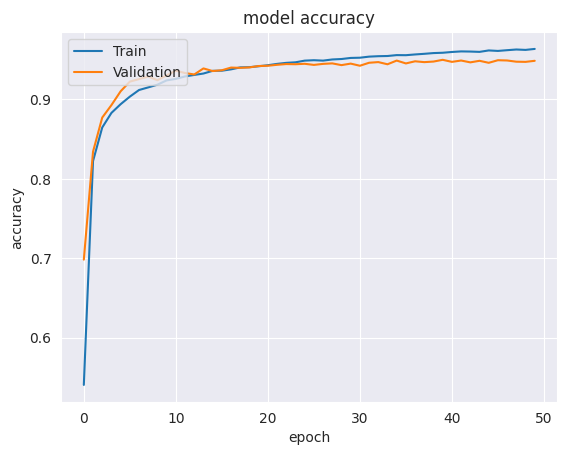

In [12]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

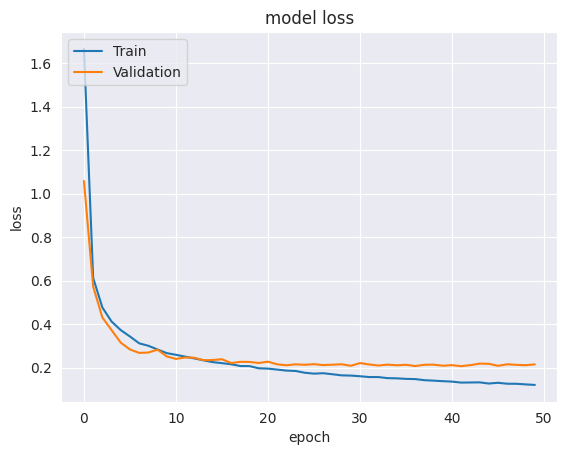

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Results on Test set

In [14]:
test_auc,test_loss,test_precision,test_recall=model.evaluate(test_gen)

1979/1979 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9571 - loss: 0.1782 - precision: 0.9623 - recall: 0.9547


In [15]:
pred=model.predict(test_gen)
predicted_labels = np.argmax(pred, axis=1)
print(predicted_labels)

# Get the true labels from the generator
true_labels = test_gen.classes

1979/1979 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
[ 6 23  2 ... 10 43 10]


In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

[[191   1   0 ...   0   0   0]
 [  1 197   0 ...   0   0   0]
 [  0   0 189 ...   0   0   0]
 ...
 [  0   0   1 ... 193   0   0]
 [  0   0   1 ...   1 194   0]
 [  0   0   0 ...   0   0 196]]


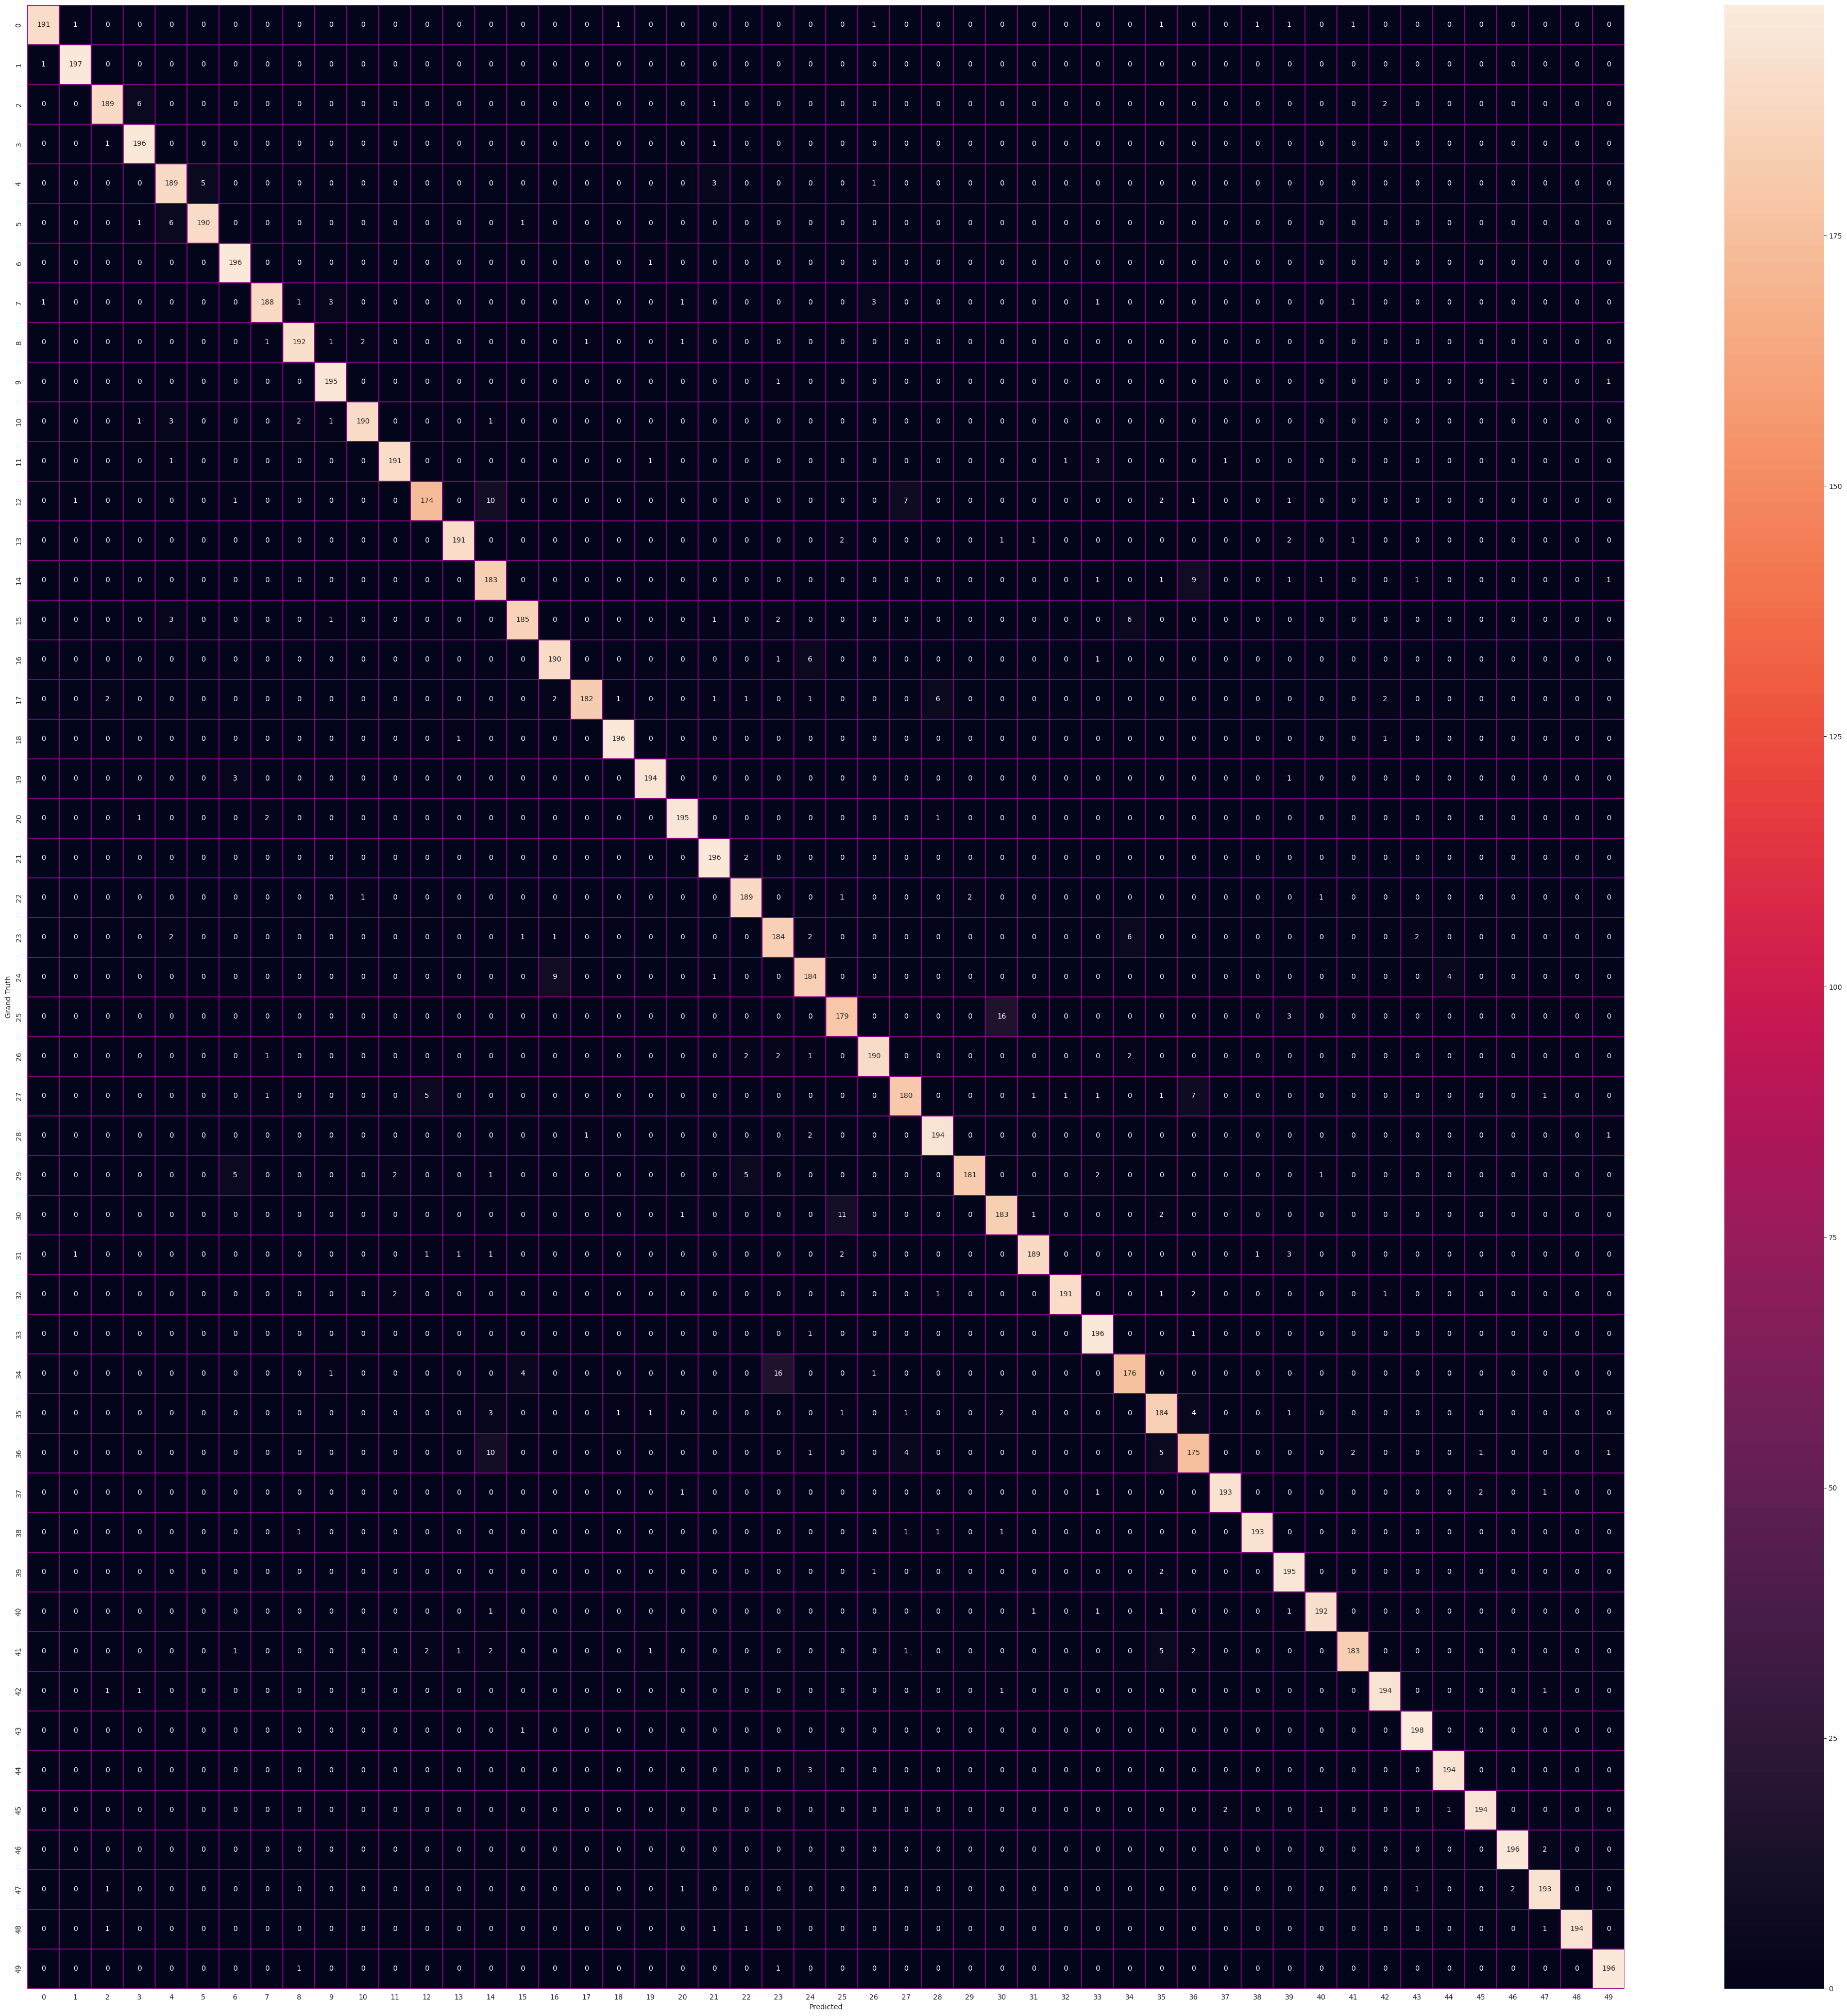

In [17]:
import seaborn as sns
f, ax = plt.subplots(figsize=(50,50))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.1, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [18]:


report=classification_report(true_labels, predicted_labels)
print("\nClassificationReport of upsampling_residual_block model:\n",report,"\n\n")




ClassificationReport of upsampling_residual_block model:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       198
           1       0.98      0.99      0.99       198
           2       0.97      0.95      0.96       198
           3       0.95      0.99      0.97       198
           4       0.93      0.95      0.94       198
           5       0.97      0.96      0.97       198
           6       0.95      0.99      0.97       197
           7       0.97      0.94      0.96       199
           8       0.97      0.97      0.97       198
           9       0.97      0.98      0.97       198
          10       0.98      0.96      0.97       198
          11       0.98      0.96      0.97       198
          12       0.96      0.88      0.92       197
          13       0.98      0.96      0.97       198
          14       0.86      0.92      0.89       198
          15       0.96      0.93      0.95       198
          16       0.9